# Компʼютерний практикум №8
Виконав студент групи ЗК-41мп Гломозда Костянтин

КЛАСИФІКАЦІЯ РУКОПИСНИХ ЧИСЕЛ ПОВНОЗВ’ЯЗНОЮ МЕРЕЖЕЮ. МЕТОДИ ОПТИМІЗАЦІЇ

# Завдання 1

Завантажуємо бібліотеки

In [ ]:
import torch
import random
import numpy as np


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Завантаження датасету

In [ ]:
import torchvision.datasets


MNIST_train = torchvision.datasets.MNIST('./data', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./data', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Перевірка

In [ ]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

print(X_train.dtype, y_train.dtype)

torch.uint8 torch.int64


Перетвоюємо дані на float

In [ ]:
X_train = X_train.float()
X_test = X_test.float()

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])


Відобразимо картинку

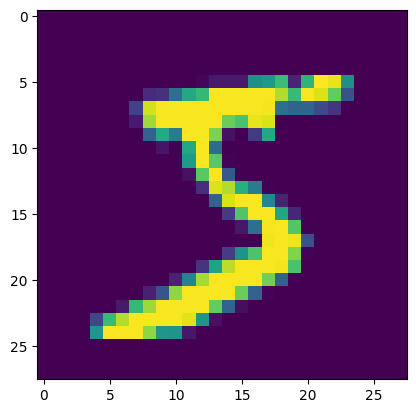

tensor(5, device='cuda:0')


In [ ]:
import matplotlib.pyplot as plt


plt.imshow(X_train[0, :, :].cpu())
plt.show()
print(y_train[0])

Перевторюємо 2д в 1д масив

In [ ]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

print(X_train.shape, X_test.shape)

torch.Size([60000, 784]) torch.Size([10000, 784])


Створюємо нейронну мережу на 784 входи та 10 виходів

In [ ]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x

mnist_net = MNISTNet(100).to(device)

Створюємо оптимізатор

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

Навчання

In [ ]:
batch_size = 100
epochs = 100
test_accuracy = []
test_loss = []
train_accuracy = []
train_loss = []

for epoch in range(epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = mnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    if epoch % (epochs / 10) == 0:
        # Test (validation)
        test_preds = mnist_net.forward(X_test)
        test_loss.append(loss(test_preds, y_test))
        test_accuracy.append((test_preds.argmax(dim=1) == y_test).float().mean())

        # Train
        train_preds = mnist_net.forward(X_train)
        train_loss.append(loss(train_preds, y_train))
        train_accuracy.append((train_preds.argmax(dim=1) == y_train).float().mean())

        print(f"Epoch: {epoch}/{epochs}, Test Accuracy: {test_accuracy[-1]:.03f}, Test Loss: {test_loss[-1]:.03f}, Train Accuracy: {train_accuracy[-1]:.03f}, Train Loss: {train_loss[-1]:.03f}")

print(f"Final Test Accuracy: {(test_preds.argmax(dim=1) == y_test).float().mean():.03f}")
print(f"Final Test Loss: {loss(test_preds, y_test):.03f}")
print(f"Final Train Accuracy: {(train_preds.argmax(dim=1) == y_train).float().mean():.03f}")
print(f"Final Train Loss: {loss(train_preds, y_train):.03f}")

Epoch: 0/100, Test Accuracy: 0.910, Test Loss: 0.343, Train Accuracy: 0.906, Train Loss: 0.352
Epoch: 10/100, Test Accuracy: 0.931, Test Loss: 0.229, Train Accuracy: 0.932, Train Loss: 0.226
Epoch: 20/100, Test Accuracy: 0.939, Test Loss: 0.209, Train Accuracy: 0.940, Train Loss: 0.197
Epoch: 30/100, Test Accuracy: 0.947, Test Loss: 0.184, Train Accuracy: 0.947, Train Loss: 0.178
Epoch: 40/100, Test Accuracy: 0.944, Test Loss: 0.186, Train Accuracy: 0.949, Train Loss: 0.168
Epoch: 50/100, Test Accuracy: 0.949, Test Loss: 0.162, Train Accuracy: 0.953, Train Loss: 0.152
Epoch: 60/100, Test Accuracy: 0.949, Test Loss: 0.160, Train Accuracy: 0.956, Train Loss: 0.143
Epoch: 70/100, Test Accuracy: 0.950, Test Loss: 0.164, Train Accuracy: 0.955, Train Loss: 0.145
Epoch: 80/100, Test Accuracy: 0.956, Test Loss: 0.143, Train Accuracy: 0.960, Train Loss: 0.132
Epoch: 90/100, Test Accuracy: 0.955, Test Loss: 0.147, Train Accuracy: 0.961, Train Loss: 0.128
Final Test Accuracy: 0.955
Final Test Los

Візуалізація результатів

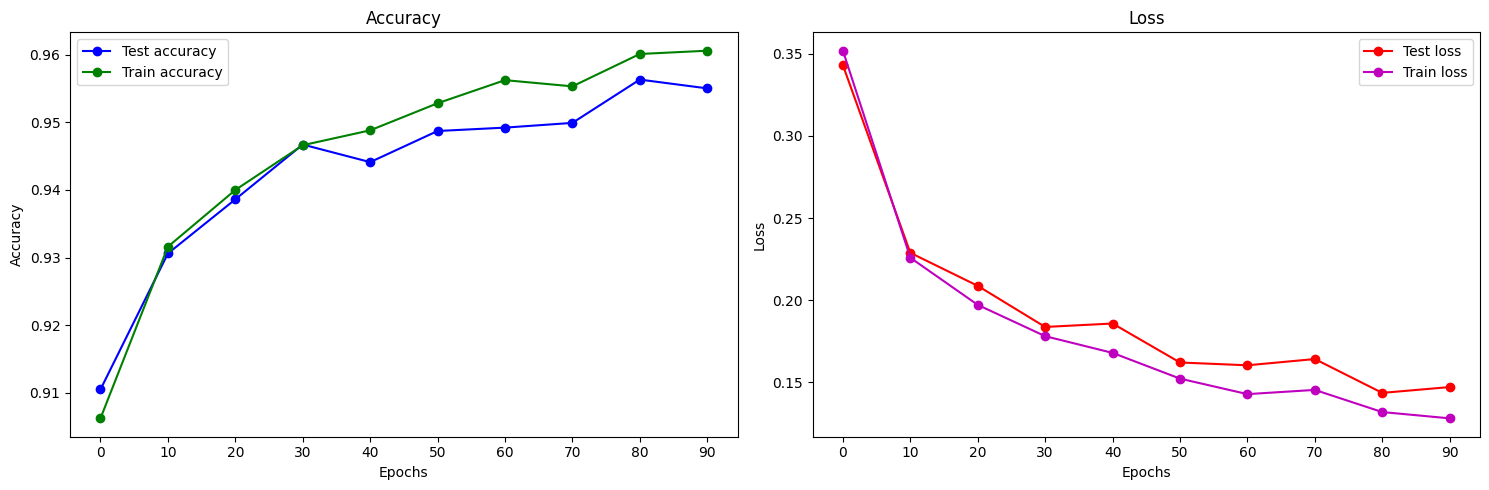

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axs[0].plot(range(0, epochs, epochs // 10), list(map(lambda x: x.cpu().detach(), test_accuracy)), 'bo-', label='Test accuracy')
axs[0].plot(range(0, epochs, epochs // 10), list(map(lambda x: x.cpu().detach(), train_accuracy)), 'go-', label='Train accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(range(0, epochs, epochs // 10))
axs[0].legend()

# Loss
axs[1].plot(range(0, epochs, epochs // 10), list(map(lambda x: x.cpu().detach(), test_loss)), 'ro-', label='Test loss')
axs[1].plot(range(0, epochs, epochs // 10), list(map(lambda x: x.cpu().detach(), train_loss)), 'mo-', label='Train loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_xticks(range(0, epochs, epochs // 10))
axs[1].legend()

plt.tight_layout()
plt.show()

Чи правда, що loss на train і validation падає однаково швидко і виходить на однакове значення, або ж у нас є перенавчання?

Наврядчи. Швидке падіння можна пояснити тим, що перша епоха проходить з випадковими вагами, після чого їх значення значно змінюються, що покращує точність та зменшує помилку.

Чи веде збільшення кількості епох (з 40 епох до 200 епох) до поліпшення метрик на валідації?

Так

Чи уповільнює torch.backends.cudnn.deterministic = True навчання
на практиці? Якщо так, то наскільки?

При значенні False навчання триває 23.1 секунди:

`
Final Test Accuracy: 0.955
Final Test Loss: 0.147
Final Train Accuracy: 0.961
Final Train Loss: 0.128
`

Значення True - 23.1 секунди:

`
Final Test Accuracy: 0.955
Final Test Loss: 0.147
Final Train Accuracy: 0.961
Final Train Loss: 0.128
`

Час навчання та результати однакові

Спробуйте різні методи градієнтного спуску. Як вибір градієнтного
спуску впливає на accuracy? Для впевненості краще проводити
один експеримент 3-5 разів на різних random seed: так ви
зрозумієте, чи дійсно позначається вплив методу або справа в
випадковості.

Спробуємо вибрати SGD

Epoch: 0/100, Test Accuracy: 0.780, Test Loss: 1.379, Train Accuracy: 0.772, Train Loss: 1.389
Epoch: 10/100, Test Accuracy: 0.906, Test Loss: 0.442, Train Accuracy: 0.908, Train Loss: 0.440
Epoch: 20/100, Test Accuracy: 0.919, Test Loss: 0.334, Train Accuracy: 0.925, Train Loss: 0.319
Epoch: 30/100, Test Accuracy: 0.924, Test Loss: 0.293, Train Accuracy: 0.935, Train Loss: 0.266
Epoch: 40/100, Test Accuracy: 0.928, Test Loss: 0.270, Train Accuracy: 0.941, Train Loss: 0.235
Epoch: 50/100, Test Accuracy: 0.931, Test Loss: 0.255, Train Accuracy: 0.946, Train Loss: 0.214
Epoch: 60/100, Test Accuracy: 0.931, Test Loss: 0.246, Train Accuracy: 0.950, Train Loss: 0.198
Epoch: 70/100, Test Accuracy: 0.932, Test Loss: 0.240, Train Accuracy: 0.953, Train Loss: 0.186
Epoch: 80/100, Test Accuracy: 0.933, Test Loss: 0.233, Train Accuracy: 0.955, Train Loss: 0.176
Epoch: 90/100, Test Accuracy: 0.934, Test Loss: 0.229, Train Accuracy: 0.957, Train Loss: 0.169
Final Test Accuracy: 0.934
Final Test Los

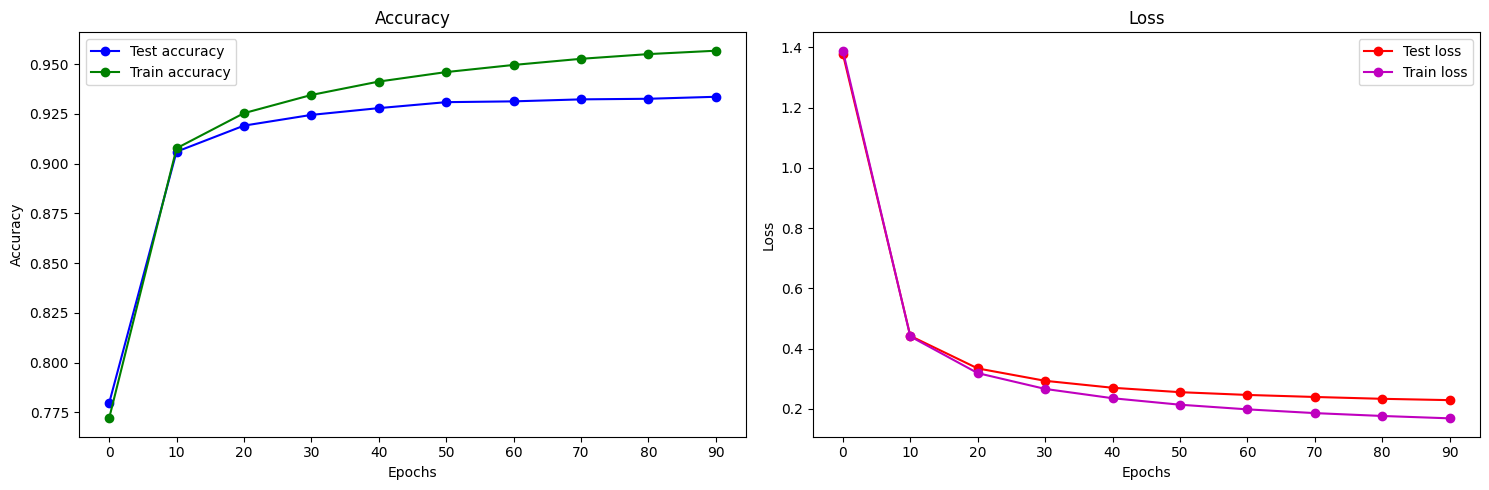

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mnist_net.parameters(), lr=1.0e-3)

batch_size = 100
epochs = 100
test_accuracy = []
test_loss = []
train_accuracy = []
train_loss = []

for epoch in range(epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = mnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    if epoch % (epochs / 10) == 0:
        # Test (validation)
        test_preds = mnist_net.forward(X_test)
        test_loss.append(loss(test_preds, y_test))
        test_accuracy.append((test_preds.argmax(dim=1) == y_test).float().mean())

        # Train
        train_preds = mnist_net.forward(X_train)
        train_loss.append(loss(train_preds, y_train))
        train_accuracy.append((train_preds.argmax(dim=1) == y_train).float().mean())

        print(f"Epoch: {epoch}/{epochs}, Test Accuracy: {test_accuracy[-1]:.03f}, Test Loss: {test_loss[-1]:.03f}, Train Accuracy: {train_accuracy[-1]:.03f}, Train Loss: {train_loss[-1]:.03f}")

print(f"Final Test Accuracy: {(test_preds.argmax(dim=1) == y_test).float().mean():.03f}")
print(f"Final Test Loss: {loss(test_preds, y_test):.03f}")
print(f"Final Train Accuracy: {(train_preds.argmax(dim=1) == y_train).float().mean():.03f}")
print(f"Final Train Loss: {loss(train_preds, y_train):.03f}")

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axs[0].plot(range(0, epochs, epochs // 10), list(map(lambda x: x.cpu().detach(), test_accuracy)), 'bo-', label='Test accuracy')
axs[0].plot(range(0, epochs, epochs // 10), list(map(lambda x: x.cpu().detach(), train_accuracy)), 'go-', label='Train accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(range(0, epochs, epochs // 10))
axs[0].legend()

# Loss
axs[1].plot(range(0, epochs, epochs // 10), list(map(lambda x: x.cpu().detach(), test_loss)), 'ro-', label='Test loss')
axs[1].plot(range(0, epochs, epochs // 10), list(map(lambda x: x.cpu().detach(), train_loss)), 'mo-', label='Train loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_xticks(range(0, epochs, epochs // 10))
axs[1].legend()

plt.tight_layout()
plt.show()

Бачимо, що результати навчання дещо гірші у порівнянні з Адам

In [ ]:
import torch

class CustomLinear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(CustomLinear, self).__init__()
        self.weights = torch.nn.Parameter(torch.randn(out_features, in_features) * 0.01)
        self.bias = torch.nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        return x @ self.weights.t() + self.bias


class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = CustomLinear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = CustomLinear(n_hidden_neurons, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x

mnist_net = MNISTNet(100).to(device)

Реалізуйте функціональність torch.nn.Linear з нуля і звірте з
оригіналом!

In [ ]:
import torch
import numpy as np

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

batch_size = 100
epochs = 100
test_accuracy = []
test_loss = []
train_accuracy = []
train_loss = []

for epoch in range(epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = mnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    if epoch % (epochs // 10) == 0:
        # Test (validation)
        with torch.no_grad():
            test_preds = mnist_net.forward(X_test)
            test_loss_value = loss(test_preds, y_test)
            test_accuracy_value = (test_preds.argmax(dim=1) == y_test).float().mean()

        test_loss.append(test_loss_value.item())
        test_accuracy.append(test_accuracy_value.item())

        # Train
        with torch.no_grad():
            train_preds = mnist_net.forward(X_train)
            train_loss_value = loss(train_preds, y_train)
            train_accuracy_value = (train_preds.argmax(dim=1) == y_train).float().mean()

        train_loss.append(train_loss_value.item())
        train_accuracy.append(train_accuracy_value.item())

        print(f"Epoch: {epoch}/{epochs}, Test Accuracy: {test_accuracy[-1]:.03f}, Test Loss: {test_loss[-1]:.03f}, Train Accuracy: {train_accuracy[-1]:.03f}, Train Loss: {train_loss[-1]:.03f}")

print(f"Final Test Accuracy: {test_accuracy[-1]:.03f}")
print(f"Final Test Loss: {test_loss[-1]:.03f}")
print(f"Final Train Accuracy: {train_accuracy[-1]:.03f}")
print(f"Final Train Loss: {train_loss[-1]:.03f}")

Epoch: 0/100, Test Accuracy: 0.961, Test Loss: 0.132, Train Accuracy: 0.971, Train Loss: 0.093
Epoch: 10/100, Test Accuracy: 0.962, Test Loss: 0.126, Train Accuracy: 0.970, Train Loss: 0.094
Epoch: 20/100, Test Accuracy: 0.962, Test Loss: 0.132, Train Accuracy: 0.971, Train Loss: 0.094
Epoch: 30/100, Test Accuracy: 0.964, Test Loss: 0.123, Train Accuracy: 0.974, Train Loss: 0.086
Epoch: 40/100, Test Accuracy: 0.964, Test Loss: 0.123, Train Accuracy: 0.974, Train Loss: 0.086
Epoch: 50/100, Test Accuracy: 0.961, Test Loss: 0.140, Train Accuracy: 0.970, Train Loss: 0.094
Epoch: 60/100, Test Accuracy: 0.964, Test Loss: 0.122, Train Accuracy: 0.973, Train Loss: 0.087
Epoch: 70/100, Test Accuracy: 0.962, Test Loss: 0.126, Train Accuracy: 0.973, Train Loss: 0.086
Epoch: 80/100, Test Accuracy: 0.962, Test Loss: 0.127, Train Accuracy: 0.974, Train Loss: 0.084
Epoch: 90/100, Test Accuracy: 0.963, Test Loss: 0.124, Train Accuracy: 0.973, Train Loss: 0.089
Final Test Accuracy: 0.963
Final Test Los

Перші результати:

`
Final Test Accuracy: 0.955
Final Test Loss: 0.147
Final Train Accuracy: 0.961
Final Train Loss: 0.128
`

Бачимо невелике покращення. Можна списати на похибку обчислень. Одже результат незмінний

Знайдіть оптимальну кількість епох для навчання, аналізуючи
графіки втрат.

Виходячи з отриманих графіків, можна вважати що оптимальна кількість епох приблизно 30-50

Нехай у нас буде 1 об'єкт x на вході з двома компонентами. Його
ми передамо в повнозв'язний шар з 3-ма нейронами і отримаємо,
відповідно, 3 виходи. Після цього напишіть цю ж функціональність
за допомогою матричного множення. Та перевірте розрахунок
похідної.

In [ ]:
import torch

# Створимо тензор x:
x = torch.tensor([[10., 20.]], requires_grad=True)

# Оригінальний повнозв’язний шар із 2-ма входами та 3-ма нейронами (виходами):
fc = torch.nn.Linear(2, 3)

# Задамо свої значення ваг та зміщень:
w = torch.tensor([[11., 12.], [21., 22.], [31., 32]], requires_grad=True)
fc.weight.data = w
b = torch.tensor([31., 32., 33.], requires_grad=True)
fc.bias.data = b

# Отримаємо вихід fc-шара:
fc_out = fc(x)

# Просумуємо виходи із fc-шара, щоб отримати скаляр:
fc_out_summed = fc_out.sum()

# Порахуємо градієнти формули fc_out_summed:
fc_out_summed.backward()

weight_grad = fc.weight.grad
bias_grad = fc.bias.grad

# Тепер зробимо розрахунки без fc-шару:
# Зазначимо, що у "w" та "b" необхідно розраховувати градієнти:
w.requires_grad_(True)
b.requires_grad_(True)

# Обчислимо вихід за допомогою матричного множення:
fc_out_alternative = torch.matmul(x, w.T) + b

# Просумуємо виходи для отримання скаляра:
our_formula = fc_out_alternative.sum()

# Порахуємо градієнти для нашої формули:
our_formula.backward()

# Аналіз результатів:
print("Порівняння виходів fc-шара та матричного множення:", fc_out == fc_out_alternative)
print('fc_weight_grad:', weight_grad)
print('our_weight_grad:', w.grad)
print('fc_bias_grad:', bias_grad)
print('out_bias_grad:', b.grad)

Порівняння виходів fc-шара та матричного множення: tensor([[True, True, True]])
fc_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
our_weight_grad: tensor([[10., 20.],
        [10., 20.],
        [10., 20.]])
fc_bias_grad: tensor([1., 1., 1.])
out_bias_grad: tensor([1., 1., 1.])


Можна зробити висновок, що як для обчислення значень на виході, так і для розрахунку градієнтів альтернативний підхід з використанням матричного множення повністю еквівалентний вбудованому шару Linear у PyTorch.

Адаптувати розроблену модель для роботи з набором даних
CIFAR 10.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Параметри
batch_size = 64
epochs = 20
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Завантаження та підготовка даних CIFAR-10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

CIFAR_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
CIFAR_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(CIFAR_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(CIFAR_test, batch_size=batch_size, shuffle=False)

print(CIFAR_train.classes)  # Виведення класів

# Нейронна мережа для CIFAR-10
class CIFARNet(nn.Module):
    def __init__(self, n_hidden_neurons):
        super(CIFARNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, n_hidden_neurons)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Перетворення зображення на вектор
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

cifar_net = CIFARNet(n_hidden_neurons=256).to(device)

# Оптимізація та функція втрат
optimizer = optim.Adam(cifar_net.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Тренування моделі
train_losses = []
test_losses = []

for epoch in range(epochs):
    cifar_net.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = cifar_net(X_batch)
        loss = loss_function(preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Валідація
    cifar_net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = cifar_net(X_batch)
            loss = loss_function(preds, y_batch)
            val_loss += loss.item()
            _, predicted = preds.max(1)
            total += y_batch.size(0)
            correct += predicted.eq(y_batch).sum().item()

    test_losses.append(val_loss / len(test_loader))
    accuracy = 100. * correct / total
    print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}, Accuracy: {accuracy:.2f}%')

print('Тренування завершено')

# Результати:
print(f"Кінцева точність на тестовому наборі: {accuracy:.2f}%")

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Epoch: 1, Train Loss: 1.634, Test Loss: 1.510, Accuracy: 46.94%
Epoch: 2, Train Loss: 1.429, Test Loss: 1.435, Accuracy: 49.95%
Epoch: 3, Train Loss: 1.320, Test Loss: 1.403, Accuracy: 50.41%
Epoch: 4, Train Loss: 1.229, Test Loss: 1.391, Accuracy: 51.88%
Epoch: 5, Train Loss: 1.149, Test Loss: 1.342, Accuracy: 53.33%
Epoch: 6, Train Loss: 1.072, Test Loss: 1.392, Accuracy: 52.73%
Epoch: 7, Train Loss: 1.003, Test Loss: 1.400, Accuracy: 53.34%
Epoch: 8, Train Loss: 0.934, Test Loss: 1.412, Accuracy: 53.13%
Epoch: 9, Train Loss: 0.869, Test Loss: 1.482, Accuracy: 53.16%
Epoch: 10, Train Loss: 0.804, Test Loss: 1.537, Accuracy: 53.33%
Epoch: 11, Train Loss: 0.748, Test Loss: 1.604, Accuracy: 52.91%
Epoch: 12, Train Loss: 0.695, Test Loss: 1.639, Accuracy: 53.25%
Epoch: 13, Train Loss: 0.647, Test Loss: 1.759, A